In [2]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Rescaling

2024-03-29 14:15:39.103999: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-29 14:15:39.185906: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-29 14:15:39.560415: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 14:15:40.871237: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Import all data as one dataframe

In [5]:
data_dir = 'training_data/trainingdata_v2/'
all_data = glob.glob(os.path.join(data_dir, "*.csv"))
combined_data = pd.concat([pd.read_csv(file) for file in all_data], ignore_index=True)
combined_data.drop(["Unnamed: 0"], axis = 1)

,Wavelength,V1,V2,Gain,Out
0,594.5,0.050000,0.050000,1,-0.000595
1,594.5,0.159722,0.050000,1,-0.000549
2,594.5,0.269444,0.050000,1,-0.000527
3,594.5,0.379167,0.050000,1,-0.000454
4,594.5,0.488889,0.050000,1,-0.000447
...,...,...,...,...,...
1187,543.1,3.816279,0.233721,1,0.000996
1188,543.1,3.862209,0.187791,1,0.001017
1189,543.1,3.908140,0.141860,1,0.001049
1190,543.1,3.954070,0.095930,1,0.001094


Adjusts output voltage for the gain factor

In [3]:
combined_data.loc[0,'Out']
new_out = []
for i in range(len(combined_data)):
    adj_out = combined_data.loc[i,'Out']*combined_data.loc[i,'Gain']
    new_out.append(adj_out)
combined_data['Out'] = new_out

Fitting model as shown in svm_regression_test.ipynb (will go into further detail)

In [68]:
x = combined_data['V1'].to_numpy()
y = combined_data['V2'].to_numpy()
z = combined_data['Gain Volts'].to_numpy(dtype = 'object')

X = np.column_stack((x, y))

param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]}
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5)
grid_search.fit(X, z)
best_c = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']

model = SVR(kernel='rbf', C=best_c, gamma=best_gamma) 
model.fit(X,z)
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1 
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 500),
                       np.linspace(x2_min, x2_max, 500))
xx_input = np.column_stack((xx1.ravel(), xx2.ravel()))
y_pred = model.predict(xx_input)

# Attempting Neural Network Fitting
The above fit is a bit rough, and part of the problem is that it's wavelength agnostic. Of course, we do have a wavelength dependency in our data. However, the reason it's wavelength agnostic is because (from what I can gather) getting the predictions we'd like from a 4D SVM regressor is difficult. The current goal is to give two inputs (wavelength and desired polarization angle) and receive the input voltages needed for the LCVR's to produce the angle. Therefore a neural net may be more apt to fit this data.

In [6]:
## Test neural network code created with Gemini (modified slightly by me)

import tensorflow as tf
from tensorflow.keras import layers

# Converts dataframe to tensor
# Note x is "input" wavelength, output voltage, Y is LCVR Volts
x = combined_data.iloc[:, [1, 5]]
y = combined_data.iloc[:, [2, 3]] 
X = tf.convert_to_tensor(x)
Y = tf.convert_to_tensor(y)

# Split into training and validation sets
# Splitting ratio (e.g., 80% for training)
split_ratio = 0.8

# Calculate the split index
split_index = int(split_ratio * len(X))

# Splitting the tensors
X_train = X[:split_index]
X_val = X[split_index:]
Y_train = Y[:split_index]
Y_val = Y[split_index:]

2024-03-29 14:17:53.428567: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [ ]:

# Model Definition
model = tf.keras.Sequential([
  layers.Dense(10, activation='relu', input_shape=(2,)),  # Hidden layer
  layers.Dense(2)  # Output layer with 2 neurons
])

# Compilation
model.compile(optimizer='adam', loss='mean_squared_error')

# Training
model.fit(X_train, Y_train, epochs=1000, validation_data=(X_val, Y_val), verbose = 2)


In [7]:
# Prediction
new_input = tf.constant([[500,-.1]])  # Input with 2 known features
prediction = model.predict(new_input)
print(prediction) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[2.6466823  0.46177444]]


This is the first iteration. It's a bit better than SVM I believe but it could use some work. Now going to try tuning the model and such to better fit the data

First scaling the data. Going to try the scaling layer included in Tensorflow.keras. Will scale based on a range from 0 to 1 for both which means we need the max values for each of our inputs.

In [7]:
max_wavelength = x['Wavelength'].max()
min_output = x['Out'].min()
max_output = x['Out'].max()
output_range = max_output - min_output

model = tf.keras.Sequential([
  Rescaling(scale=[1./max_wavelength, 1./output_range], offset=[0, min_output]),
  layers.Dense(10, activation='relu', input_shape=(2,)),  # Hidden layer
  layers.Dense(2)  # Output layer with 2 neurons
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=300, validation_data=(X_val, Y_val), verbose = 2)

Epoch 1/300


/home/jimmy/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 - 1s - 29ms/step - loss: 3.5568 - val_loss: 4.5585
Epoch 2/300
30/30 - 0s - 3ms/step - loss: 3.1740 - val_loss: 4.1254
Epoch 3/300
30/30 - 0s - 2ms/step - loss: 2.8661 - val_loss: 3.7544
Epoch 4/300
30/30 - 0s - 2ms/step - loss: 2.6006 - val_loss: 3.4365
Epoch 5/300
30/30 - 0s - 3ms/step - loss: 2.3837 - val_loss: 3.1541
Epoch 6/300
30/30 - 0s - 2ms/step - loss: 2.2084 - val_loss: 2.9087
Epoch 7/300
30/30 - 0s - 2ms/step - loss: 2.0739 - val_loss: 2.6978
Epoch 8/300
30/30 - 0s - 2ms/step - loss: 1.9721 - val_loss: 2.5312
Epoch 9/300
30/30 - 0s - 2ms/step - loss: 1.8965 - val_loss: 2.4009
Epoch 10/300
30/30 - 0s - 2ms/step - loss: 1.8457 - val_loss: 2.2937
Epoch 11/300
30/30 - 0s - 2ms/step - loss: 1.8122 - val_loss: 2.2090
Epoch 12/300
30/30 - 0s - 2ms/step - loss: 1.7856 - val_loss: 2.1365
Epoch 13/300
30/30 - 0s - 2ms/step - loss: 1.7623 - val_loss: 2.0870
Epoch 14/300
30/30 - 0s - 2ms/step - loss: 1.7495 - val_loss: 2.0395
Epoch 15/300
30/30 - 0s - 2ms/step - loss: 1.7348 - va

KeyboardInterrupt: 

This is somewhat helpful, as we have lower RMS error in less time. Now will try adding ReLU layers

In [22]:
max_wavelength = x['Wavelength'].max()
min_output = x['Out'].min()
max_output = x['Out'].max()
output_range = max_output - min_output

model = tf.keras.Sequential([
  Rescaling(scale=[1./max_wavelength, 1./output_range], offset=[0, min_output]),
  layers.Dense(10, activation='relu', input_shape=(2,)),
  layers.Dense(10, activation='relu', input_shape=(2,)),  # Hidden layer
  layers.Dense(2)  # Output layer with 2 neurons
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=300, validation_data=(X_val, Y_val), verbose = 2)

Epoch 1/300
35/35 - 1s - 27ms/step - loss: 3.8983 - val_loss: 4.5996
Epoch 2/300
35/35 - 0s - 2ms/step - loss: 3.6428 - val_loss: 4.3448
Epoch 3/300
35/35 - 0s - 2ms/step - loss: 3.4032 - val_loss: 4.0079
Epoch 4/300
35/35 - 0s - 2ms/step - loss: 3.0920 - val_loss: 3.5524
Epoch 5/300
35/35 - 0s - 2ms/step - loss: 2.7010 - val_loss: 3.0128
Epoch 6/300
35/35 - 0s - 2ms/step - loss: 2.2983 - val_loss: 2.4757
Epoch 7/300
35/35 - 0s - 2ms/step - loss: 1.9639 - val_loss: 2.0556
Epoch 8/300
35/35 - 0s - 2ms/step - loss: 1.7760 - val_loss: 1.8476
Epoch 9/300
35/35 - 0s - 3ms/step - loss: 1.7307 - val_loss: 1.7846
Epoch 10/300
35/35 - 0s - 2ms/step - loss: 1.7247 - val_loss: 1.7780
Epoch 11/300
35/35 - 0s - 2ms/step - loss: 1.7223 - val_loss: 1.7763
Epoch 12/300
35/35 - 0s - 2ms/step - loss: 1.7201 - val_loss: 1.7689
Epoch 13/300
35/35 - 0s - 2ms/step - loss: 1.7175 - val_loss: 1.7754
Epoch 14/300
35/35 - 0s - 2ms/step - loss: 1.7150 - val_loss: 1.7651
Epoch 15/300
35/35 - 0s - 2ms/step - loss:

KeyboardInterrupt: 

This is even better and continually decreases the loss... Sometimes? I need to figure out how to make that more consistent

Rescaling input, target, and validation data. There should be an easier way but I wanted to have the scale factors stored as well for recovery later. (Maybe make this a function when fully implemented?)

NOTE: does not currently store scale factors actually but it does scale properly for now

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#Y training
rs_Y_train = tf.concat([
    tf.convert_to_tensor(scaler.fit(Y_train[:,0:1]).transform(Y_train[:, 0:1])),
    tf.convert_to_tensor(scaler.fit(Y_train[:,1:]).transform(Y_train[:, 1:]))
], axis=1)

# X training
rs_X_train = tf.concat([
    tf.convert_to_tensor(scaler.fit(X_train[:,0:1]).transform(X_train[:, 0:1])),
    tf.convert_to_tensor(scaler.fit(X_train[:,1:]).transform(X_train[:, 1:]))
], axis=1)

#Y validation
# Want same scaler on training and validation data
rs_Y_val = tf.concat([
    tf.convert_to_tensor(scaler.fit(Y_train[:,0:1]).transform(Y_val[:, 0:1])),
    tf.convert_to_tensor(scaler.fit(Y_train[:,1:]).transform(Y_val[:, 1:]))
], axis=1)

#X validation
rs_X_val = tf.concat([
    tf.convert_to_tensor(scaler.fit(X_train[:,0:1]).transform(X_val[:, 0:1])),
    tf.convert_to_tensor(scaler.fit(X_train[:,1:]).transform(X_val[:, 1:]))
], axis=1)

In [42]:
model = tf.keras.Sequential([
  layers.Dense(10, activation='relu', input_shape=(2,)),
  layers.Dropout(0.1),
  layers.Dense(10, activation='relu', input_shape=(2,)),  # Hidden layer
  layers.Dropout(0.1),
  layers.Dense(2)  # Output layer with 2 neurons
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(rs_X_train, rs_Y_train, epochs=2000, validation_data=(rs_X_val, rs_Y_val), verbose = 2)

Epoch 1/2000


/home/jimmy/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 - 1s - 29ms/step - loss: 0.2742 - val_loss: 0.2308
Epoch 2/2000
35/35 - 0s - 2ms/step - loss: 0.1651 - val_loss: 0.1698
Epoch 3/2000
35/35 - 0s - 2ms/step - loss: 0.1390 - val_loss: 0.1429
Epoch 4/2000
35/35 - 0s - 2ms/step - loss: 0.1371 - val_loss: 0.1321
Epoch 5/2000
35/35 - 0s - 3ms/step - loss: 0.1304 - val_loss: 0.1294
Epoch 6/2000
35/35 - 0s - 2ms/step - loss: 0.1250 - val_loss: 0.1274
Epoch 7/2000
35/35 - 0s - 2ms/step - loss: 0.1222 - val_loss: 0.1263
Epoch 8/2000
35/35 - 0s - 2ms/step - loss: 0.1215 - val_loss: 0.1251
Epoch 9/2000
35/35 - 0s - 2ms/step - loss: 0.1199 - val_loss: 0.1244
Epoch 10/2000
35/35 - 0s - 2ms/step - loss: 0.1167 - val_loss: 0.1236
Epoch 11/2000
35/35 - 0s - 2ms/step - loss: 0.1165 - val_loss: 0.1228
Epoch 12/2000
35/35 - 0s - 3ms/step - loss: 0.1136 - val_loss: 0.1216
Epoch 13/2000
35/35 - 0s - 3ms/step - loss: 0.1158 - val_loss: 0.1212
Epoch 14/2000
35/35 - 0s - 3ms/step - loss: 0.1152 - val_loss: 0.1208
Epoch 15/2000
35/35 - 0s - 3ms/step - los

KeyboardInterrupt: 

# Programmatically testing different network layers

Scaling the data has helped dramatically, but it would help to know what kind of layers would be useful. This is a little slow but will be a good way to empirically measure the loss for different functions. Just starting with two layers:

In [56]:
act_funcs = ['leaky_relu','relu','sigmoid','tanh']
losses = []
layernum = 0

for i in range(len(act_funcs)):
    for j in range (len(act_funcs)):
        layernum += 1
        print("Training Layer Combination " + str(layernum) + " out of " + str((len(act_funcs))**2))
        model = tf.keras.Sequential([
        layers.Dense(2),
        layers.Dense(10, activation=act_funcs[i], input_shape=(2,)),
        layers.Dropout(0.1),
        layers.Dense(10, activation='relu', input_shape=(2,)),  # Hidden layer
        layers.Dropout(0.1),
        layers.Dense(2)  # Output layer with 2 neurons
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        history = model.fit(rs_X_train, rs_Y_train, epochs=300, validation_data=(rs_X_val, rs_Y_val), verbose = 0)
        final_epoch_loss = history.history['loss'][-1]
        losses.append({'Layer 1' : act_funcs[i], 'Layer 2': act_funcs[j], 'Loss': final_epoch_loss})

Training Layer Combination 1 out of 16


/home/jimmy/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Layer Combination 2 out of 16
Training Layer Combination 3 out of 16
Training Layer Combination 4 out of 16
Training Layer Combination 5 out of 16
Training Layer Combination 6 out of 16
Training Layer Combination 7 out of 16
Training Layer Combination 8 out of 16
Training Layer Combination 9 out of 16
Training Layer Combination 10 out of 16
Training Layer Combination 11 out of 16
Training Layer Combination 12 out of 16
Training Layer Combination 13 out of 16
Training Layer Combination 14 out of 16
Training Layer Combination 15 out of 16
Training Layer Combination 16 out of 16


In [60]:
lossframe = pd.DataFrame(losses)
lossframe

,Layer 1,Layer 2,Loss,Layer 1 Neurons,Layer 2 Neurons
0,leaky_relu,leaky_relu,0.087611,NaN,NaN
1,leaky_relu,relu,0.091828,NaN,NaN
2,leaky_relu,sigmoid,0.089810,NaN,NaN
3,leaky_relu,tanh,0.089719,NaN,NaN
4,relu,leaky_relu,0.091886,NaN,NaN
5,relu,relu,0.092415,NaN,NaN
6,relu,sigmoid,0.094143,NaN,NaN
7,relu,tanh,0.086029,NaN,NaN
8,sigmoid,leaky_relu,0.104498,NaN,NaN
9,sigmoid,relu,0.104680,NaN,NaN


Right now it'slooking like relu -> tanh may be the way to go. Now testing number of neurons. Also basing sequential layers on initial layer size as a 'filtering' method

In [91]:
losses = []
max_neurons = 64
min_neurons = 30
layernum = 0

for i in range(4,8):
    max_neurons = 2**i
    layernum += 1
    print("Training Layer Combination " + str(layernum) + " out of " + str(max_neurons - min_neurons))
    model = tf.keras.Sequential([
    layers.Dense(2),
    layers.Dense(max_neurons, activation='relu', input_shape=(2,)),
    layers.Dropout(0.1),
    layers.Dense(int(max_neurons/2), activation='tanh', input_shape=(2,)), 
    layers.Dropout(0.1),
    layers.Dense(int(max_neurons/4), activation='relu', input_shape=(2,)),
    layers.Dropout(0.1),
    layers.Dense(2) 
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(rs_X_train, rs_Y_train, epochs=300, validation_data=(rs_X_val, rs_Y_val), verbose = 0)
    final_epoch_loss = history.history['loss'][-1]
    losses.append({'Layer 1 Neurons' : i, 'Layer 2 Neurons': str(i/2),'Layer 3 Neurons': str(i/4), 'Loss': final_epoch_loss})

Training Layer Combination 1 out of -14
Training Layer Combination 2 out of 2
Training Layer Combination 3 out of 34
Training Layer Combination 4 out of 98


In [92]:
lossframe = pd.DataFrame(losses)
lossframe

,Layer 1 Neurons,Layer 2 Neurons,Layer 3 Neurons,Loss
0,4,2.0,1.0,0.094603
1,5,2.5,1.25,0.084221
2,6,3.0,1.5,0.078768
3,7,3.5,1.75,0.074874


In [41]:
rs_X_train_shape = tf.reshape(rs_X_train, [len(rs_X_train),1, 2])
rs_Y_train_shape = tf.reshape(rs_Y_train, [len(rs_Y_train),1, 2])
rs_X_val_shape = tf.reshape(rs_X_val, [len(rs_X_val),1, 2])
rs_Y_val_shape = tf.reshape(rs_Y_val, [len(rs_Y_val),1, 2])
rs_X_train_shape

<tf.Tensor: shape=(953, 1, 2), dtype=float64, numpy=
array([[[1.        , 0.9226546 ]],

       [[1.        , 0.92469183]],

       [[1.        , 0.92565864]],

       ...,

       [[0.43267108, 0.95759815]],

       [[0.43267108, 0.95773627]],

       [[0.43267108, 0.95797797]]])>

In [52]:
max_neurons = 2**8
drop_time = 0.2
model = tf.keras.Sequential([
        layers.Dense(2),
        layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(1,2), padding = "same"),
        layers.MaxPooling1D(pool_size=2,padding = "same"),
        layers.Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(1,2), padding = "same"),
        layers.MaxPooling1D(pool_size=2, padding = "same"),
        layers.Dense(max_neurons, activation='relu', input_shape=(2,)),
        layers.Dropout(drop_time),
        layers.Dense(int(max_neurons/2), activation='tanh', input_shape=(2,)), 
        layers.Dropout(drop_time),
        layers.Dense(int(max_neurons/4), activation='relu', input_shape=(2,)),
        layers.Dropout(drop_time),
        layers.Dense(2) 
        ])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(rs_X_train_shape, rs_Y_train_shape, epochs=20000, validation_data=(rs_X_val_shape, rs_Y_val_shape), verbose = 2)

Epoch 1/20000
30/30 - 2s - 78ms/step - loss: 0.1347 - val_loss: 0.1145
Epoch 2/20000
30/30 - 0s - 4ms/step - loss: 0.1157 - val_loss: 0.1265
Epoch 3/20000
30/30 - 0s - 5ms/step - loss: 0.1122 - val_loss: 0.1351
Epoch 4/20000
30/30 - 0s - 4ms/step - loss: 0.1081 - val_loss: 0.1607
Epoch 5/20000
30/30 - 0s - 5ms/step - loss: 0.1064 - val_loss: 0.1827
Epoch 6/20000
30/30 - 0s - 4ms/step - loss: 0.1028 - val_loss: 0.1925
Epoch 7/20000
30/30 - 0s - 4ms/step - loss: 0.0975 - val_loss: 0.2144
Epoch 8/20000
30/30 - 0s - 5ms/step - loss: 0.0940 - val_loss: 0.1840
Epoch 9/20000
30/30 - 0s - 5ms/step - loss: 0.0922 - val_loss: 0.2273
Epoch 10/20000
30/30 - 0s - 5ms/step - loss: 0.0913 - val_loss: 0.1977
Epoch 11/20000
30/30 - 0s - 4ms/step - loss: 0.0888 - val_loss: 0.2054
Epoch 12/20000
30/30 - 0s - 4ms/step - loss: 0.0879 - val_loss: 0.2225
Epoch 13/20000
30/30 - 0s - 5ms/step - loss: 0.0885 - val_loss: 0.2161
Epoch 14/20000
30/30 - 0s - 5ms/step - loss: 0.0860 - val_loss: 0.2237
Epoch 15/20000

KeyboardInterrupt: 

Need to now undo scaling for predictions to actually know what's happening. This will *definitely* just be a function in lcvr_learning when this is all implemented there

In [120]:
pred_wave = [[480]]
pred_volts =[[0.03]]

rs_input = tf.concat([
    tf.convert_to_tensor(scaler.fit(X_train[:,0:1]).transform(pred_wave)),
    tf.convert_to_tensor(scaler.fit(X_train[:,1:]).transform(pred_volts))
], axis=1)

prediction = model.predict(rs_input)

rs_output = tf.concat([
    tf.convert_to_tensor(scaler.fit(Y_train[:,0:1]).inverse_transform([[prediction[0,0]]])),
    tf.convert_to_tensor(scaler.fit(Y_train[:,1:]).inverse_transform([[prediction[0,1]]]))
], axis=1)
print(rs_output) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
tf.Tensor([[0.33869303 3.15758747]], shape=(1, 2), dtype=float64)


In [15]:
tf.convert_to_tensor(scaler.fit(Y_train[:,0:1]).inverse_transform([[.0687]]))

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.321365]])>

In [30]:
rs_X_train

<tf.Tensor: shape=(953, 2), dtype=float64, numpy=
array([[1.        , 0.9226546 ],
       [1.        , 0.92469183],
       [1.        , 0.92565864],
       ...,
       [0.43267108, 0.95759815],
       [0.43267108, 0.95773627],
       [0.43267108, 0.95797797]])>

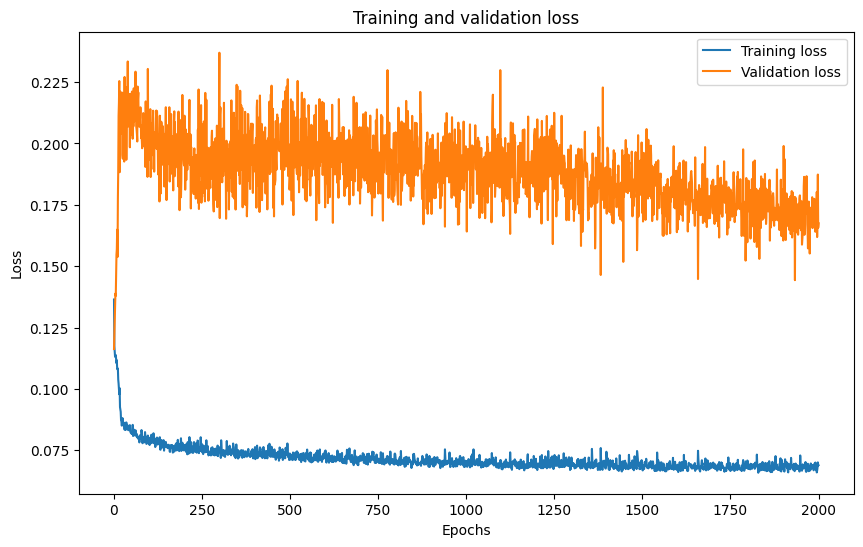

In [53]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, history.history['loss'], label='Training loss')
plt.plot(epochs, history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
initial_lr = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps=1000,  # Decay every 1000 steps
    decay_rate=0.95,    
)

max_neurons = 2**8
drop_time = 0.2
model = tf.keras.Sequential([
        layers.Dense(2),
        layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(1,2), padding = "same"),
        layers.MaxPooling1D(pool_size=2,padding = "same"),
        layers.Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(1,2), padding = "same"),
        layers.MaxPooling1D(pool_size=2, padding = "same"),
        layers.Dense(max_neurons, activation='relu', input_shape=(2,)),
        layers.Dropout(drop_time),
        layers.Dense(int(max_neurons/2), activation='tanh', input_shape=(2,)), 
        layers.Dropout(drop_time),
        layers.Dense(int(max_neurons/4), activation='relu', input_shape=(2,)),
        layers.Dropout(drop_time),
        layers.Dense(2) 
        ])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='mean_squared_error')
history = model.fit(rs_X_train_shape, rs_Y_train_shape, epochs=20000, validation_data=(rs_X_val_shape, rs_Y_val_shape), verbose = 2)

Epoch 1/20000


30/30 - 3s - 86ms/step - loss: 0.1230 - val_loss: 0.1280
Epoch 2/20000
30/30 - 0s - 5ms/step - loss: 0.1156 - val_loss: 0.1181
Epoch 3/20000
30/30 - 0s - 5ms/step - loss: 0.1152 - val_loss: 0.1214
Epoch 4/20000
30/30 - 0s - 5ms/step - loss: 0.1126 - val_loss: 0.1301
Epoch 5/20000
30/30 - 0s - 5ms/step - loss: 0.1117 - val_loss: 0.1157
Epoch 6/20000
30/30 - 0s - 5ms/step - loss: 0.1133 - val_loss: 0.1248
Epoch 7/20000
30/30 - 0s - 5ms/step - loss: 0.1106 - val_loss: 0.1291
Epoch 8/20000
30/30 - 0s - 5ms/step - loss: 0.1110 - val_loss: 0.1223
Epoch 9/20000
30/30 - 0s - 4ms/step - loss: 0.1104 - val_loss: 0.1316
Epoch 10/20000
30/30 - 0s - 4ms/step - loss: 0.1111 - val_loss: 0.1132
Epoch 11/20000
30/30 - 0s - 4ms/step - loss: 0.1127 - val_loss: 0.1189
Epoch 12/20000
30/30 - 0s - 5ms/step - loss: 0.1113 - val_loss: 0.1204
Epoch 13/20000
30/30 - 0s - 5ms/step - loss: 0.1110 - val_loss: 0.1260
Epoch 14/20000
30/30 - 0s - 5ms/step - loss: 0.1125 - val_loss: 0.1189
Epoch 15/20000
30/30 - 0s - 

KeyboardInterrupt: 

In [64]:
losses = []
max_neurons = 2**6
act_funcs = ['leaky_relu','relu','sigmoid','tanh']
drop_time = 0.2
num = 0

for l in range(len(act_funcs)):
        for m in range(len(act_funcs)):
                for n in range(len(act_funcs)):
                        num += 1
                        print("Worming on combo # " + str(num))
                        model = tf.keras.Sequential([
                                layers.Dense(2),
                                layers.Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(1,2), padding = "same"),
                                layers.Dropout(drop_time),
                                layers.MaxPooling1D(pool_size=2,padding = "same"),
                                layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(1,2), padding = "same"),
                                layers.Dropout(drop_time),
                                layers.MaxPooling1D(pool_size=2, padding = "same"),
                                layers.Dense(max_neurons, activation=act_funcs[l], input_shape=(2,)),
                                layers.Dropout(drop_time),
                                layers.Dense(int(max_neurons/2), activation=act_funcs[m], input_shape=(2,)), 
                                layers.Dropout(drop_time),
                                layers.Dense(int(max_neurons/4), activation=act_funcs[n], input_shape=(2,)),
                                layers.Dropout(drop_time),
                                layers.Dense(2) 
                                ])
                        model.compile(optimizer='adam', loss='mean_squared_error')
                        history = model.fit(rs_X_train_shape, rs_Y_train_shape, epochs=400, validation_data=(rs_X_val_shape, rs_Y_val_shape), verbose = 0)
                        final_epoch_loss = history.history['loss'][-1]
                        losses.append({'Layer 1 Neurons' : i, 'Layer 2 Neurons': str(i/2),'Layer 3 Neurons': str(i/4), 
                                       '1st AF': act_funcs[j],'2nd AF': act_funcs[k],'3rd AF': act_funcs[l],'4th AF': act_funcs[m],'5th AF': act_funcs[n],
                                         'Loss': final_epoch_loss})

Worming on combo # 1


/home/jimmy/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/home/jimmy/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Worming on combo # 2
Worming on combo # 3
Worming on combo # 4
Worming on combo # 5
Worming on combo # 6
Worming on combo # 7
Worming on combo # 8
Worming on combo # 9
Worming on combo # 10
Worming on combo # 11
Worming on combo # 12
Worming on combo # 13
Worming on combo # 14
Worming on combo # 15
Worming on combo # 16
Worming on combo # 17
Worming on combo # 18
Worming on combo # 19
Worming on combo # 20
Worming on combo # 21
Worming on combo # 22
Worming on combo # 23
Worming on combo # 24
Worming on combo # 25
Worming on combo # 26
Worming on combo # 27
Worming on combo # 28
Worming on combo # 29
Worming on combo # 30
Worming on combo # 31
Worming on combo # 32
Worming on combo # 33
Worming on combo # 34
Worming on combo # 35
Worming on combo # 36
Worming on combo # 37
Worming on combo # 38
Worming on combo # 39
Worming on combo # 40
Worming on combo # 41
Worming on combo # 42
Worming on combo # 43
Worming on combo # 44
Worming on combo # 45
Worming on combo # 46
Worming on combo #

In [65]:
losses

[{'Layer 1 Neurons': 1,
  'Layer 2 Neurons': '0.5',
  'Layer 3 Neurons': '0.25',
  '1st AF': 'relu',
  '2nd AF': 'relu',
  '3rd AF': 'leaky_relu',
  '4th AF': 'leaky_relu',
  '5th AF': 'leaky_relu',
  'Loss': 0.07557154446840286},
 {'Layer 1 Neurons': 1,
  'Layer 2 Neurons': '0.5',
  'Layer 3 Neurons': '0.25',
  '1st AF': 'relu',
  '2nd AF': 'relu',
  '3rd AF': 'leaky_relu',
  '4th AF': 'leaky_relu',
  '5th AF': 'relu',
  'Loss': 0.0785466805100441},
 {'Layer 1 Neurons': 1,
  'Layer 2 Neurons': '0.5',
  'Layer 3 Neurons': '0.25',
  '1st AF': 'relu',
  '2nd AF': 'relu',
  '3rd AF': 'leaky_relu',
  '4th AF': 'leaky_relu',
  '5th AF': 'sigmoid',
  'Loss': 0.09402038156986237},
 {'Layer 1 Neurons': 1,
  'Layer 2 Neurons': '0.5',
  'Layer 3 Neurons': '0.25',
  '1st AF': 'relu',
  '2nd AF': 'relu',
  '3rd AF': 'leaky_relu',
  '4th AF': 'leaky_relu',
  '5th AF': 'tanh',
  'Loss': 0.07618919759988785},
 {'Layer 1 Neurons': 1,
  'Layer 2 Neurons': '0.5',
  'Layer 3 Neurons': '0.25',
  '1st AF':

In [66]:
pd.DataFrame(losses).to_csv('losstest2.csv')

In [67]:
pd.DataFrame(losses)['Loss'].min()

0.07512854784727097

Making some changes. Now keeping tanh for final 3 layers and altering convolution kernals. Also switching to Huber loss which is more robust to noise

In [83]:
from tensorflow.keras import backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [93]:
model = tf.keras.Sequential([
        layers.Dense(2),
        layers.Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(1,2), padding = "same"),
        layers.Dropout(drop_time),
        layers.MaxPooling1D(pool_size=2,padding = "same"),
        layers.BatchNormalization(),
        layers.Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(1,2), padding = "same"),
        layers.Dropout(drop_time),
        layers.MaxPooling1D(pool_size=2, padding = "same"),
        layers.Dense(max_neurons, activation='tanh', input_shape=(2,), kernel_regularizer='l2'),
        layers.Dropout(drop_time),
        layers.Dense(int(max_neurons/2), activation='tanh', input_shape=(2,)), 
        layers.Dropout(drop_time),
        layers.Dense(int(max_neurons/4), activation='tanh', input_shape=(2,)),
        layers.Dropout(drop_time),
        layers.Dense(2) 
        ])
model.compile(optimizer='adam', loss=tf.keras.losses.Huber(delta = 5.0), metrics = [rmse])
history = model.fit(rs_X_train_shape, rs_Y_train_shape, epochs=2000, validation_data=(rs_X_val_shape, rs_Y_val_shape), verbose = 2)

Epoch 1/2000
30/30 - 3s - 112ms/step - loss: 0.4913 - rmse: 0.4487 - val_loss: 0.4414 - val_rmse: 0.4231
Epoch 2/2000
30/30 - 0s - 4ms/step - loss: 0.3726 - rmse: 0.3842 - val_loss: 0.3465 - val_rmse: 0.3985
Epoch 3/2000
30/30 - 0s - 4ms/step - loss: 0.2883 - rmse: 0.3618 - val_loss: 0.2680 - val_rmse: 0.3762
Epoch 4/2000
30/30 - 0s - 4ms/step - loss: 0.2245 - rmse: 0.3531 - val_loss: 0.2090 - val_rmse: 0.3612
Epoch 5/2000
30/30 - 0s - 4ms/step - loss: 0.1761 - rmse: 0.3456 - val_loss: 0.1679 - val_rmse: 0.3577
Epoch 6/2000
30/30 - 0s - 4ms/step - loss: 0.1406 - rmse: 0.3426 - val_loss: 0.1371 - val_rmse: 0.3543
Epoch 7/2000
30/30 - 0s - 4ms/step - loss: 0.1145 - rmse: 0.3394 - val_loss: 0.1136 - val_rmse: 0.3482
Epoch 8/2000
30/30 - 0s - 4ms/step - loss: 0.0974 - rmse: 0.3421 - val_loss: 0.0969 - val_rmse: 0.3434
Epoch 9/2000
30/30 - 0s - 4ms/step - loss: 0.0831 - rmse: 0.3370 - val_loss: 0.0854 - val_rmse: 0.3404
Epoch 10/2000
30/30 - 0s - 4ms/step - loss: 0.0750 - rmse: 0.3386 - val

KeyError: 'rmse'

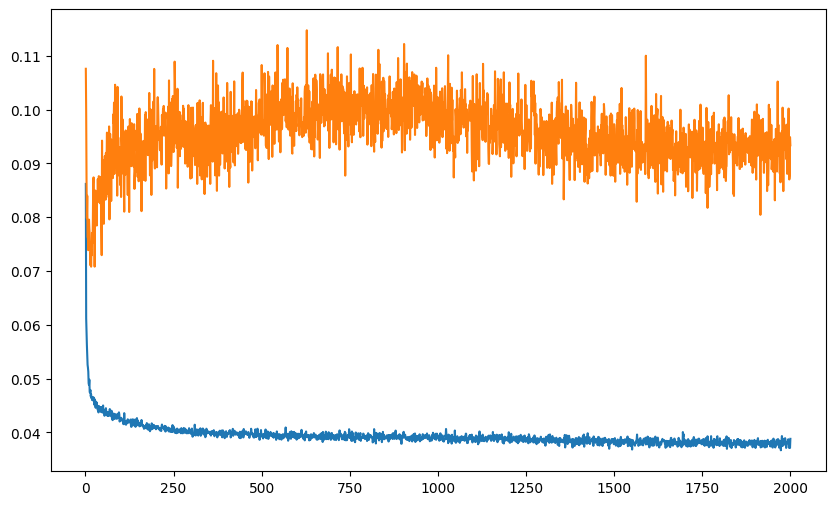

In [82]:
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, history.history['loss'], label='Training loss')
plt.plot(epochs, history.history['val_loss'], label='Validation loss')
plt.plot(epochs, history.history['rmse'], label='RMSE')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

New strategy: Give one LCVR setting as a context input, which is also received as an output. This should give a model where given 3 of the 4 features we can predict the final (which is not very noisy at all), and then gives us the relationship between LCVR 1 and 2 thoroughly

In [97]:
scaler = MinMaxScaler(feature_range=(0, 1))

#Y training
rs_Y_train = tf.concat([
    tf.convert_to_tensor(scaler.fit(Y_train[:,0:1]).transform(Y_train[:, 0:1])),
    tf.convert_to_tensor(scaler.fit(Y_train[:,1:]).transform(Y_train[:, 1:])),
], axis=1)

# X training - Now Wavelength, output, and LCVR 1
rs_X_train = tf.concat([
    tf.convert_to_tensor(scaler.fit(X_train[:,0:1]).transform(X_train[:, 0:1])),
    tf.convert_to_tensor(scaler.fit(X_train[:,1:]).transform(X_train[:, 1:])),
    tf.convert_to_tensor(scaler.fit(Y_train[:,0:1]).transform(Y_train[:, 0:1]))
], axis=1)

#Y validation
# Want same scaler on training and validation data
rs_Y_val = tf.concat([
    tf.convert_to_tensor(scaler.fit(Y_train[:,0:1]).transform(Y_val[:, 0:1])),
    tf.convert_to_tensor(scaler.fit(Y_train[:,1:]).transform(Y_val[:, 1:]))
], axis=1)

#X validation - Now Wavelength, output, and LCVR 1
rs_X_val = tf.concat([
    tf.convert_to_tensor(scaler.fit(X_train[:,0:1]).transform(X_val[:, 0:1])),
    tf.convert_to_tensor(scaler.fit(X_train[:,1:]).transform(X_val[:, 1:])),
    tf.convert_to_tensor(scaler.fit(Y_train[:,0:1]).transform(Y_val[:, 0:1]))
], axis=1)



rs_X_train_shape = tf.reshape(rs_X_train, [len(rs_X_train),1, 3])
rs_Y_train_shape = tf.reshape(rs_Y_train, [len(rs_Y_train),1, 2])
rs_X_val_shape = tf.reshape(rs_X_val, [len(rs_X_val),1, 3])
rs_Y_val_shape = tf.reshape(rs_Y_val, [len(rs_Y_val),1, 2])

In [150]:
losses = []
max_neurons = 2**8
drop_time = 0.2
l1_str = 0.00005
l2_str = 0.06

model = tf.keras.Sequential([
        layers.Dense(3),
        layers.Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(1,3), padding = "same"),
        layers.Dropout(drop_time),
        layers.MaxPooling1D(pool_size=2,padding = "same"),
        layers.BatchNormalization(),
        layers.Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(1,3), padding = "same"),
        layers.Dropout(drop_time),
       # layers.MaxPooling1D(pool_size=2, padding = "same"),
        layers.Dense(max_neurons, activation='tanh', input_shape=(2,), kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_str, l2=l2_str)),
        layers.Dropout(drop_time),
        layers.Dense(int(max_neurons/2), activation='tanh', input_shape=(2,),kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_str, l2=l2_str)), 
        layers.Dropout(drop_time),
        layers.Dense(int(max_neurons/4), activation='tanh', input_shape=(2,),kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_str, l2=l2_str)),
        layers.Dropout(drop_time),
        layers.Dense(2) 
        ])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(rs_X_train_shape, rs_Y_train_shape, epochs=2000, validation_data=(rs_X_val_shape, rs_Y_val_shape), verbose = 2)

Epoch 1/2000


30/30 - 3s - 105ms/step - loss: 14.2063 - val_loss: 9.8361
Epoch 2/2000
30/30 - 0s - 5ms/step - loss: 7.0215 - val_loss: 4.7193
Epoch 3/2000
30/30 - 0s - 6ms/step - loss: 3.3131 - val_loss: 2.2186
Epoch 4/2000
30/30 - 0s - 5ms/step - loss: 1.5370 - val_loss: 1.0505
Epoch 5/2000
30/30 - 0s - 5ms/step - loss: 0.7212 - val_loss: 0.5242
Epoch 6/2000
30/30 - 0s - 5ms/step - loss: 0.3615 - val_loss: 0.2906
Epoch 7/2000
30/30 - 0s - 5ms/step - loss: 0.2030 - val_loss: 0.1906
Epoch 8/2000
30/30 - 0s - 5ms/step - loss: 0.1391 - val_loss: 0.1438
Epoch 9/2000
30/30 - 0s - 5ms/step - loss: 0.1089 - val_loss: 0.1218
Epoch 10/2000
30/30 - 0s - 5ms/step - loss: 0.0963 - val_loss: 0.1106
Epoch 11/2000
30/30 - 0s - 5ms/step - loss: 0.0903 - val_loss: 0.1000
Epoch 12/2000
30/30 - 0s - 5ms/step - loss: 0.0860 - val_loss: 0.0960
Epoch 13/2000
30/30 - 0s - 5ms/step - loss: 0.0839 - val_loss: 0.0929
Epoch 14/2000
30/30 - 0s - 5ms/step - loss: 0.0824 - val_loss: 0.0879
Epoch 15/2000
30/30 - 0s - 5ms/step - l

KeyboardInterrupt: 

In [160]:
tf.convert_to_tensor(scaler.fit(Y_train[:,0:1]).inverse_transform([[.058]]))

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.2791]])>

Now altering learning rate to attempt to fix plateauing
NOTE: initial learning rate of 0.0005, 1000 decay steps, and rate of 0.95 has already improves loss plateau, but should vary these parameters to try and find the optimal fit

In [159]:
initial_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps=1000,  # Decay every 1000 steps
    decay_rate=0.95,    
)

max_neurons = 2**8
drop_time = 0.2
l1_str = 0.00005
l2_str = 0.06

model = tf.keras.Sequential([
        layers.Dense(3),
        layers.Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(1,3), padding = "same"),
        layers.Dropout(drop_time),
        layers.MaxPooling1D(pool_size=2,padding = "same"),
        layers.BatchNormalization(),
        layers.Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(1,3), padding = "same"),
        layers.Dropout(drop_time),
       # layers.MaxPooling1D(pool_size=2, padding = "same"),
        layers.Dense(max_neurons, activation='tanh', input_shape=(2,), kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_str, l2=l2_str)),
        layers.Dropout(drop_time),
        layers.Dense(int(max_neurons/2), activation='tanh', input_shape=(2,),kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_str, l2=l2_str)), 
        layers.Dropout(drop_time),
        layers.Dense(int(max_neurons/4), activation='tanh', input_shape=(2,),kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_str, l2=l2_str)),
        layers.Dropout(drop_time),
        layers.Dense(2) 
        ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='mean_squared_error')
history = model.fit(rs_X_train_shape, rs_Y_train_shape, epochs=20000, validation_data=(rs_X_val_shape, rs_Y_val_shape), verbose = 2)

Epoch 1/20000
30/30 - 3s - 102ms/step - loss: 14.3090 - val_loss: 9.9674
Epoch 2/20000
30/30 - 0s - 5ms/step - loss: 7.1406 - val_loss: 4.8286
Epoch 3/20000
30/30 - 0s - 5ms/step - loss: 3.3981 - val_loss: 2.2809
Epoch 4/20000
30/30 - 0s - 5ms/step - loss: 1.5874 - val_loss: 1.0895
Epoch 5/20000
30/30 - 0s - 5ms/step - loss: 0.7484 - val_loss: 0.5472
Epoch 6/20000
30/30 - 0s - 5ms/step - loss: 0.3742 - val_loss: 0.3029
Epoch 7/20000
30/30 - 0s - 5ms/step - loss: 0.2120 - val_loss: 0.1975
Epoch 8/20000
30/30 - 0s - 5ms/step - loss: 0.1436 - val_loss: 0.1563
Epoch 9/20000
30/30 - 0s - 5ms/step - loss: 0.1110 - val_loss: 0.1267
Epoch 10/20000
30/30 - 0s - 5ms/step - loss: 0.0972 - val_loss: 0.1154
Epoch 11/20000
30/30 - 0s - 5ms/step - loss: 0.0904 - val_loss: 0.1044
Epoch 12/20000
30/30 - 0s - 5ms/step - loss: 0.0879 - val_loss: 0.1048
Epoch 13/20000
30/30 - 0s - 5ms/step - loss: 0.0859 - val_loss: 0.0924
Epoch 14/20000
30/30 - 0s - 5ms/step - loss: 0.0847 - val_loss: 0.0950
Epoch 15/200

KeyboardInterrupt: 